# Signal/Background Classification using Boosted Decision Trees

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, f1_score
import helper_function_module_BDT as hfm
from tqdm import tqdm
import os
from sklearn.inspection import permutation_importance

SEED = 63821
np.random.seed(SEED)

In [2]:
import os
print(os.getcwd())

/teamspace/studios/this_studio/all/BDT/minpt20


## 1. Data Loading

In [3]:
signal = hfm.load_json_data("/teamspace/studios/this_studio/all/txt_data_preprocess/onlyAny2bj_onlyAny1p/ppzaxbba_ax15_200k_minpt20_15jets_etafiltered_corrected_onlyAny2j_onlyAny1p_processed.json")
background = hfm.load_json_data("/teamspace/studios/this_studio/all/txt_data_preprocess/onlyAny2bj_onlyAny1p/background_ppbba_500k_minpt20_15jets_etafiltered_corrected_onlyAny2j_onlyAny1p_processed.json")

Loading event data from /teamspace/studios/this_studio/all/txt_data_preprocess/onlyAny2bj_onlyAny1p/ppzaxbba_ax15_200k_minpt20_15jets_etafiltered_corrected_onlyAny2j_onlyAny1p_processed.json...
--- Successfully loaded 552 events :)
Loading event data from /teamspace/studios/this_studio/all/txt_data_preprocess/onlyAny2bj_onlyAny1p/background_ppbba_500k_minpt20_15jets_etafiltered_corrected_onlyAny2j_onlyAny1p_processed.json...
--- Successfully loaded 1893 events :)


In [4]:
signal[23]

{'eventno': 12955,
 'jets': [{'jet_index': 1,
   'Eta': -1.77194,
   'Phi': -0.68918,
   'pT': 77.8443,
   'Px': 60.0778,
   'Py': -49.5015,
   'Pz': -222.334,
   'E': 235.567,
   'btag': 1},
  {'jet_index': 2,
   'Eta': 0.00425883,
   'Phi': 1.39803,
   'pT': 43.1848,
   'Px': 7.42385,
   'Py': 42.5419,
   'Pz': 0.183917,
   'E': 43.1851,
   'btag': 1},
  {'jet_index': 3,
   'Eta': 0.599452,
   'Phi': -2.93688,
   'pT': 30.5675,
   'Px': -29.9293,
   'Py': -6.21396,
   'Pz': 19.4411,
   'E': 36.2261,
   'btag': 0}],
 'photons': [{'isophoton_index': 1,
   'Eta': -0.94256,
   'Phi': 1.34825,
   'pT': 28.4146,
   'Px': 6.27149,
   'Py': 27.7138,
   'Pz': -30.928,
   'E': 41.9992}],
 'num_btag_jets': 2,
 'num_isophoton': 1}

In [5]:
signal_df= hfm.prepare_data_for_model(signal, required_jets=2, required_photons=1, event_label = 1)

if signal_df is not None:
    print("\n--- Data Shapes Before Splitting ---")
    print(f"Signal DF shape: {signal_df.shape}")

background_df= hfm.prepare_data_for_model(background, required_jets=2, required_photons=1, event_label = 0)

if background_df is not None:
    print("\n--- Data Shapes Before Splitting ---")
    print(f"Background DF shape: {background_df.shape}")

Processing 552 events to extract features...


Extracting Features: 100%|██████████| 552/552 [00:00<00:00, 6199.26it/s]



--- Data Shapes Before Splitting ---
Signal DF shape: (552, 5)
Processing 1893 events to extract features...


Extracting Features: 100%|██████████| 1893/1893 [00:00<00:00, 5607.36it/s]


--- Data Shapes Before Splitting ---
Background DF shape: (1893, 5)


In [6]:
signal_df.head()

,isophoton_pT,deltaR_jet12,invMass_2j1p,inv_mass_2j,event_label
292,43.9066,0.557936,95.628387,13.256282,1
336,36.4948,3.010080,137.099103,91.450451,1
614,19.6124,3.642989,347.880585,324.918827,1
1210,71.1914,2.644860,380.707739,265.213163,1
3167,37.6917,2.652595,172.312530,112.832597,1


In [7]:
background_df.head()

,isophoton_pT,deltaR_jet12,invMass_2j1p,inv_mass_2j,event_label
541,20.8574,0.541099,61.967540,17.724672,0
1087,12.3144,3.163884,149.021284,135.646229,0
1619,18.6661,3.769648,161.401193,137.281558,0
2298,10.3313,3.497819,108.507152,98.248791,0
2751,15.6680,3.123787,155.639812,135.456430,0


In [8]:
data = pd.concat([signal_df, background_df], axis = 0)

In [9]:
data = data.sample(frac=1, random_state = SEED)
data.head()

,isophoton_pT,deltaR_jet12,invMass_2j1p,inv_mass_2j,event_label
35603,12.7839,3.093153,102.158931,82.006813,0
114860,23.7395,0.594413,112.103456,17.194089,1
115354,34.9980,2.513597,146.701859,67.882562,1
408682,15.2817,2.947770,89.210290,63.388739,0
34247,34.6419,3.536292,318.735047,281.747404,1


In [10]:
X, y = data.iloc[:,:-1].values, data.loc[:,'event_label'].values.astype(int)

In [11]:
X.shape

(2445, 4)

## 2. Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=SEED,
                                                   stratify = y)

print("\n--- Data Shapes After Splitting ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


--- Data Shapes After Splitting ---
X_train shape: (1711, 4)
X_test shape: (734, 4)
y_train shape: (1711,)
y_test shape: (734,)


# Random Forest Classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
param_grid_forest = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 20]
}
grid_search_forest = GridSearchCV(RandomForestClassifier(random_state=SEED),
                          param_grid=param_grid_forest,
                          cv=5,
                          n_jobs=-1)

In [15]:
grid_search_forest.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=63821),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 200, 300, 500]})

Best Hyperparameters: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 500}


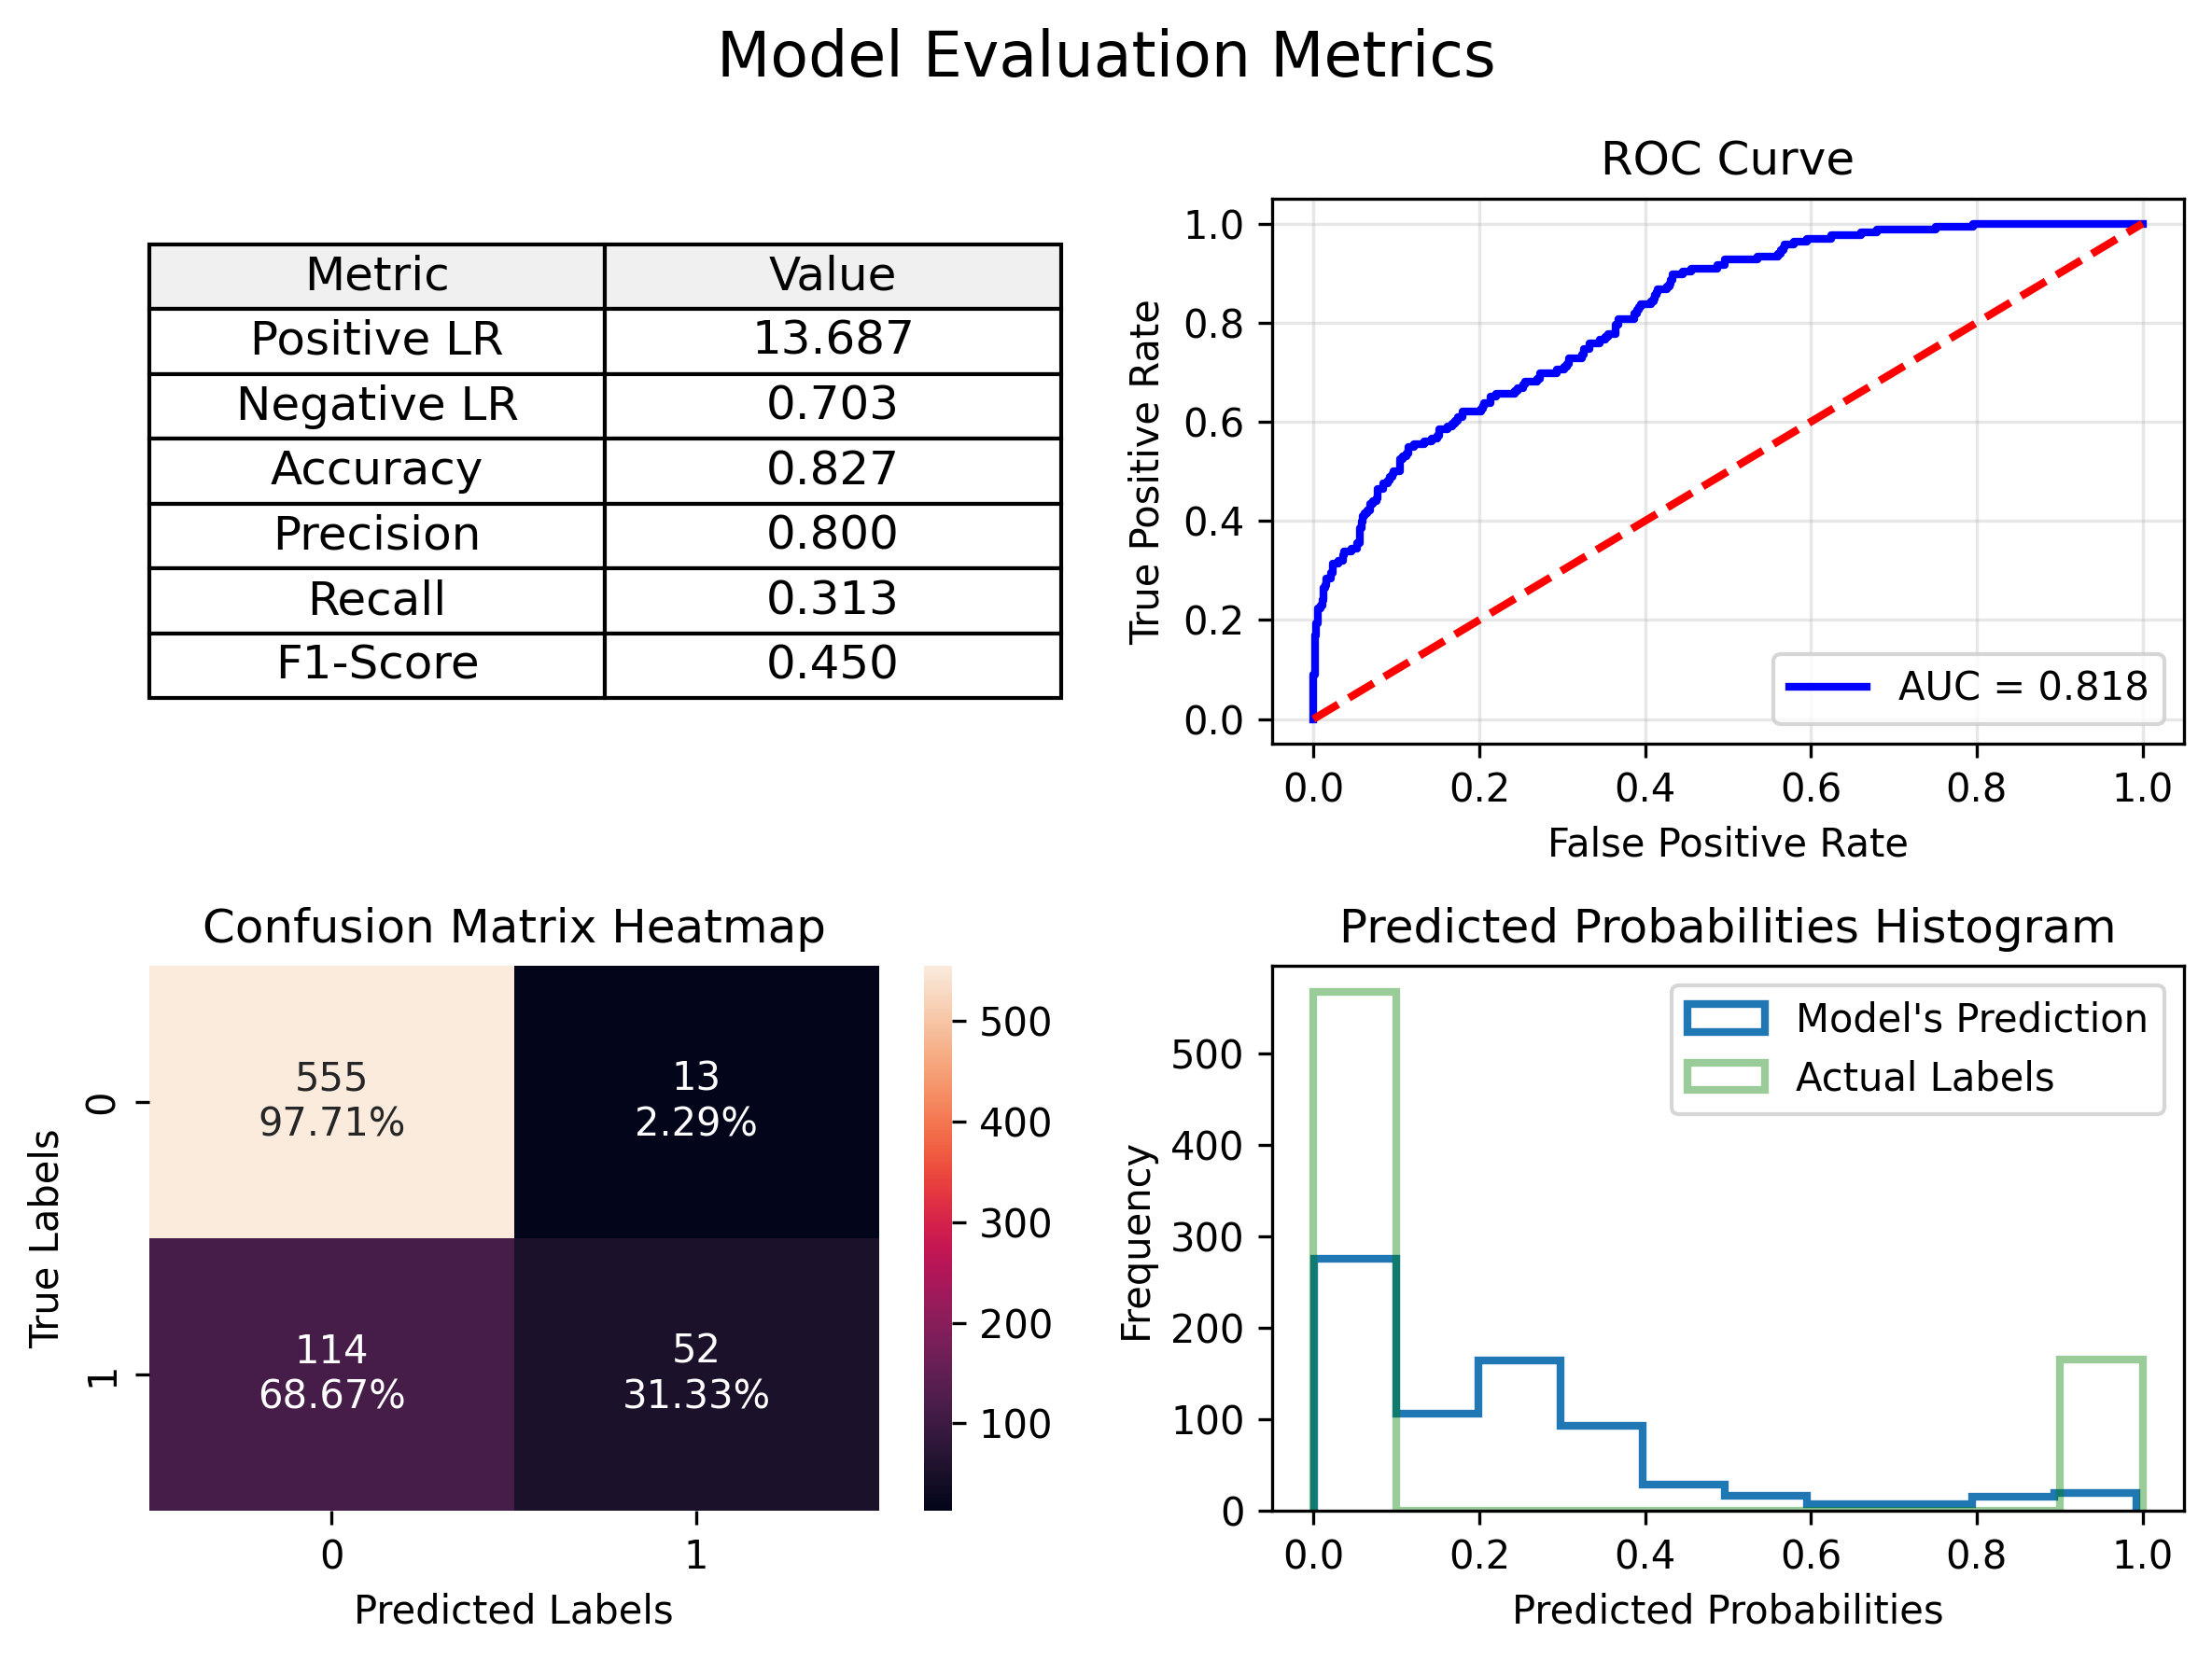

In [16]:
best_model_rf = grid_search_forest.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)
y_pred_prob_rf = best_model_rf.predict_proba(X_test)[:, 1] #For getting probabilites of class label 1

print(f'Best Hyperparameters: {grid_search_forest.best_params_}')

y_pred_label_rf = [1 if (y_prob >= 0.5) else 0 for y_prob in y_pred_prob_rf]
hfm.eval_model(y_test, y_pred_prob_rf, y_pred_label_rf, save_fig = False, save_fig_path = 'ax45_RFEval_Metrics.png')

# Gradient Boosting Classifier

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

In [18]:
param_grid_grad = {
    'n_estimators': [50, 100, 200, 400],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.001]
}

In [19]:
grid_search_grad = GridSearchCV(GradientBoostingClassifier(random_state=SEED),
                          param_grid=param_grid_grad,
                          cv=5,
                          n_jobs=-1)

In [20]:
grid_search_grad.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=63821),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.001],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]})

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}


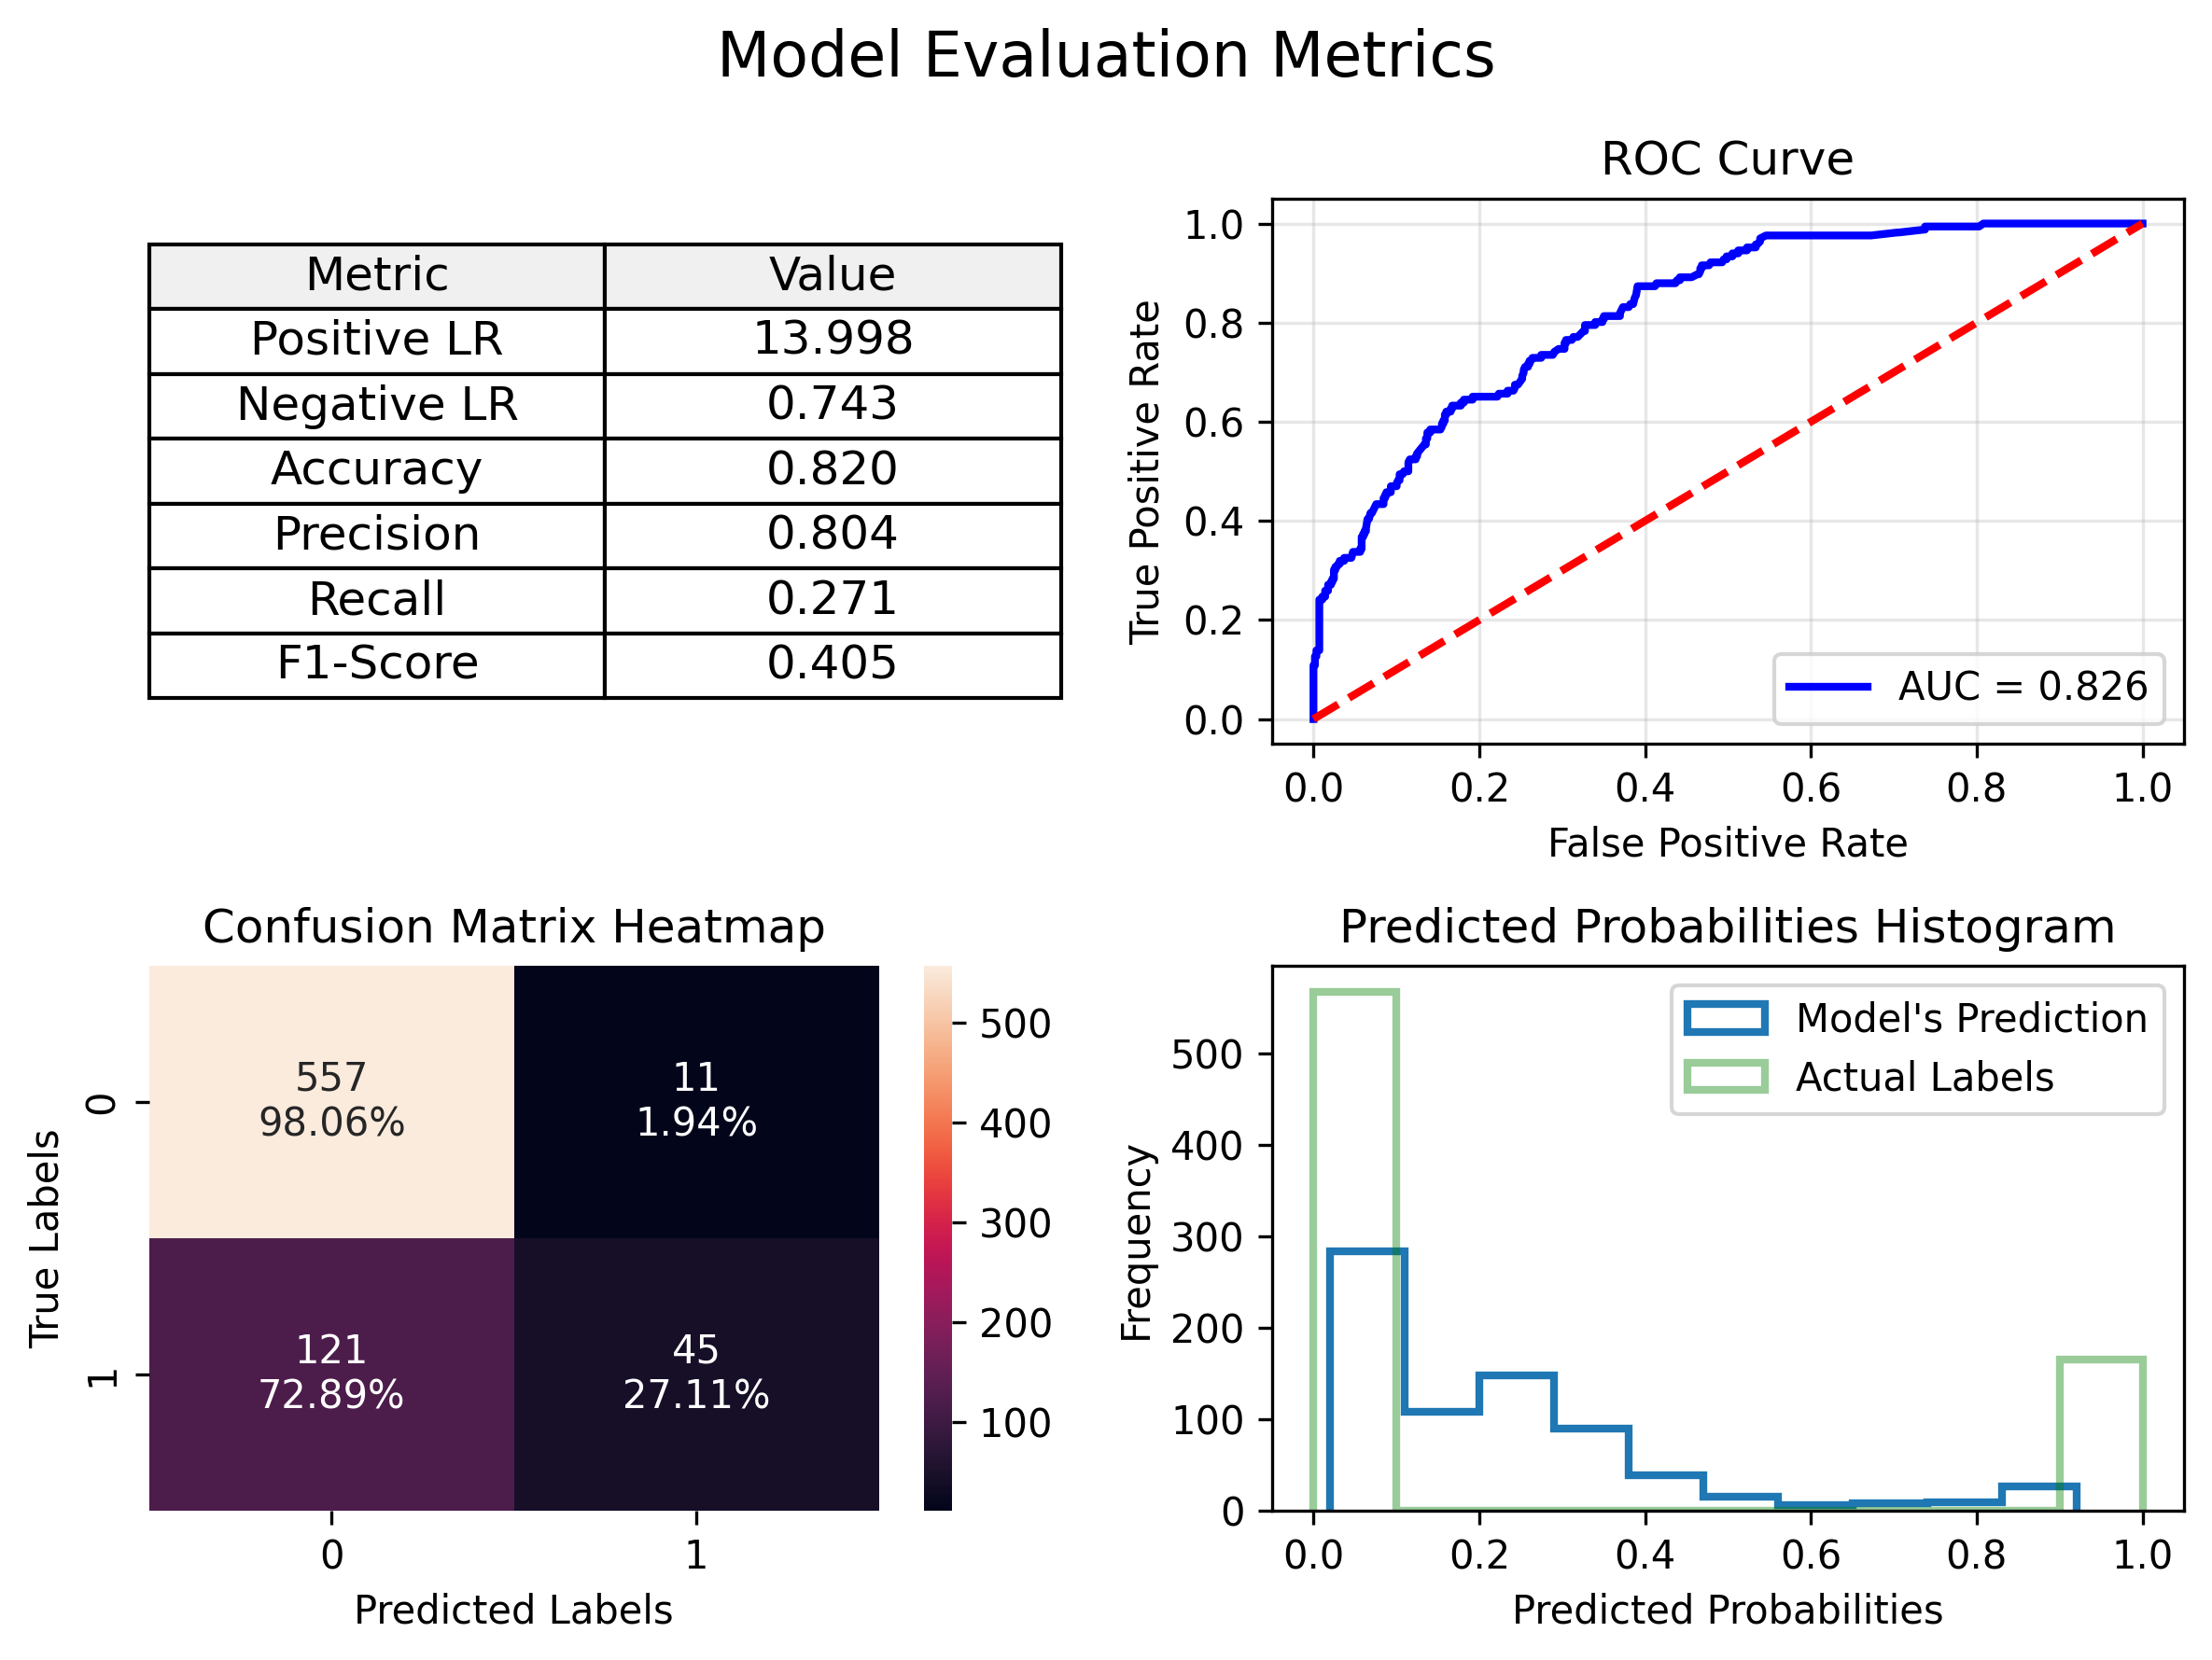

In [21]:
best_model_gb = grid_search_grad.best_estimator_
y_pred_gb = best_model_gb.predict(X_test)
y_pred_prob_gb = best_model_gb.predict_proba(X_test)[:, 1] #For getting probabilites of class label 1

print(f'Best Hyperparameters: {grid_search_grad.best_params_}')

y_pred_label_gb = [1 if (y_prob >= 0.5) else 0 for y_prob in y_pred_prob_gb]
hfm.eval_model(y_test, y_pred_prob_gb, y_pred_label_gb, save_fig = False, save_fig_path = 'ax45_GBEval_Metrics.png')

# Extracting Feature Importances - RandomForest

In [22]:
features_col = data.columns[:-1]


--- Calculating Impurity-Based Feature Importance (MDI) ---
inv_mass_2j     0.293795
isophoton_pT    0.288781
deltaR_jet12    0.247398
invMass_2j1p    0.170027
dtype: float64


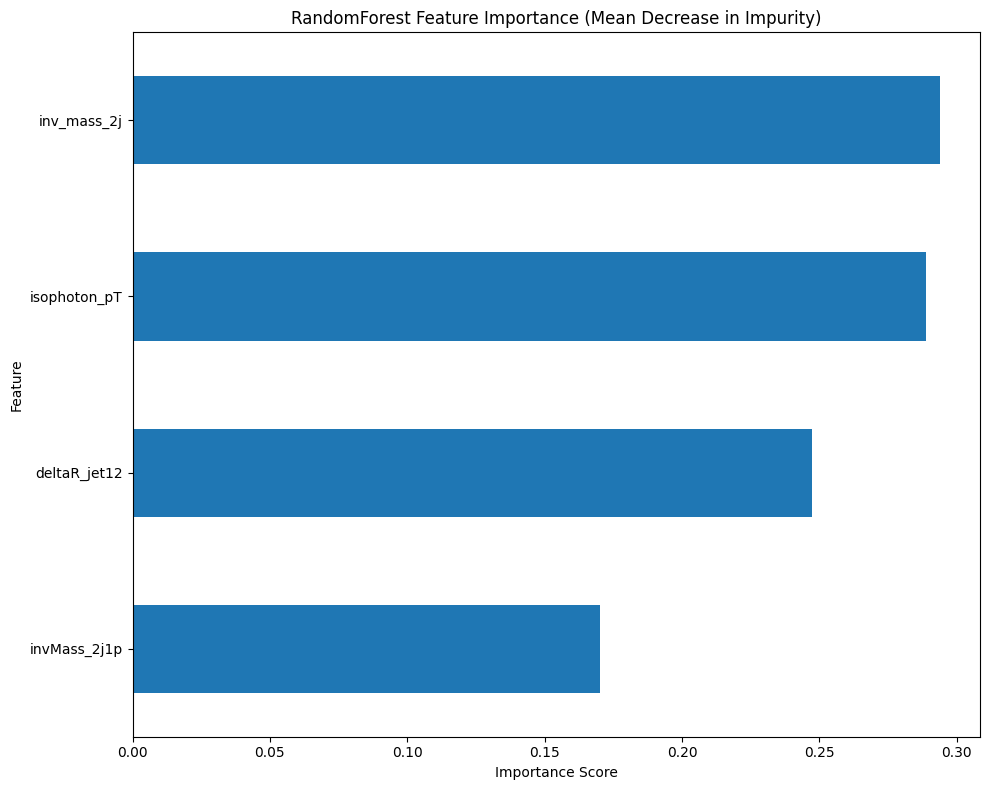

In [23]:
print("\n--- Calculating Impurity-Based Feature Importance (MDI) ---")
# Get importance scores directly from the trained model
rf_importances_mdi = best_model_rf.feature_importances_

# Create a Pandas Series for easy handling and sorting
rf_importances_mdi = pd.Series(rf_importances_mdi, index=features_col)
rf_importances_mdi = rf_importances_mdi.sort_values(ascending=False)

print(rf_importances_mdi)

# --- Visualize MDI Importances ---
plt.figure(figsize=(10, 8))
rf_importances_mdi.plot(kind='barh')
plt.title("RandomForest Feature Importance (Mean Decrease in Impurity)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.tight_layout()
plt.show()

## Permutation Importance - RandomForest


--- Calculating Permutation Importance (on Test Set) ---

Features Permutation Importance on Test Set, metric='average_precision'):
isophoton_pT    0.173820
invMass_2j1p    0.140367
deltaR_jet12    0.075929
inv_mass_2j     0.061706
dtype: float64


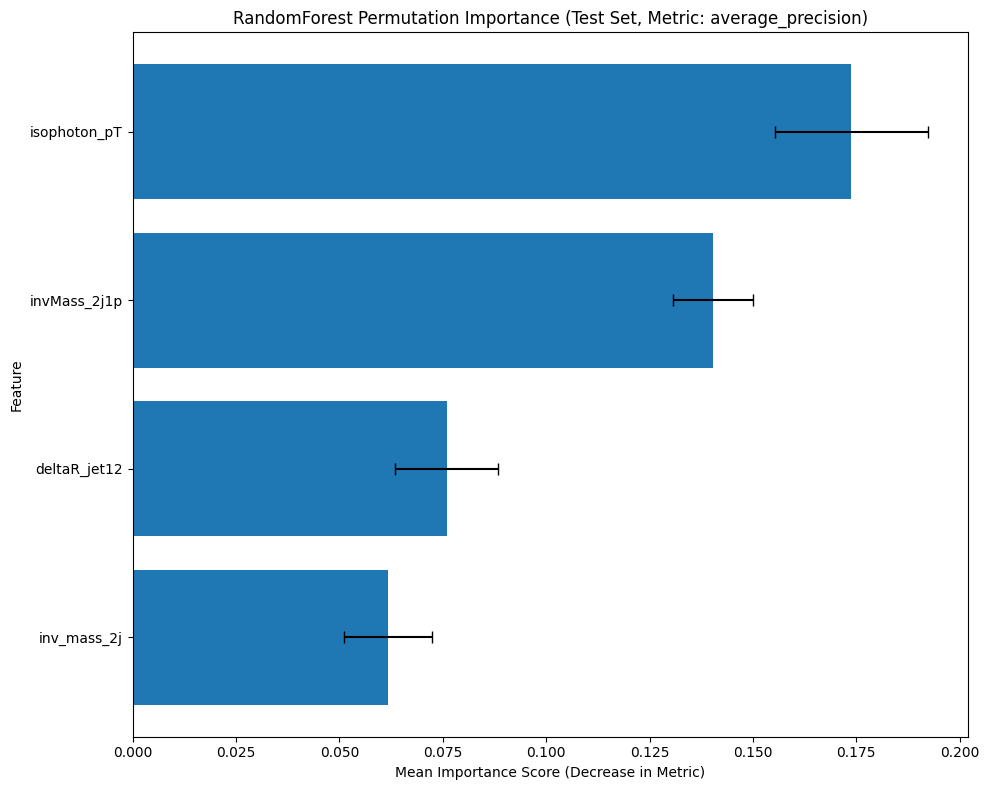

In [24]:
print("\n--- Calculating Permutation Importance (on Test Set) ---")


# Choose a scoring metric - accuracy, roc_auc, f1, balanced_accuracy etc.
# For imbalanced data, 'roc_auc', 'f1_weighted', or 'balanced_accuracy' are often better than 'accuracy'
scoring_metric = 'average_precision'

# Calculate permutation importance
# n_repeats: Number of times to shuffle each feature for stability
rf_perm_importance_result = permutation_importance(
    estimator=best_model_rf,
    X=X_test,
    y=y_test,
    scoring=scoring_metric,
    n_repeats=10, # Increase for more stable results, but slower
    random_state=SEED,
    n_jobs=-1 # Use multiple cores if available
)

# Extract mean and standard deviation of importance scores
rf_importances_perm_mean = rf_perm_importance_result.importances_mean
rf_importances_perm_std = rf_perm_importance_result.importances_std

# Create a Pandas Series for easy handling
rf_perm_importances = pd.Series(rf_importances_perm_mean, index=features_col)
rf_perm_importances = rf_perm_importances.sort_values(ascending=False)

print(f"\nFeatures Permutation Importance on Test Set, metric='{scoring_metric}'):")
print(rf_perm_importances)

# --- Visualize Permutation Importances ---
plt.figure(figsize=(10, 8))
# Get sorted indices for plotting std deviations correctly
sorted_idx = rf_perm_importances.index
plt.barh(sorted_idx, rf_perm_importances[sorted_idx],
         xerr=rf_importances_perm_std[rf_perm_importances.index.get_indexer(sorted_idx)], # Map std dev to sorted order
         capsize=4)
plt.title(f"RandomForest Permutation Importance (Test Set, Metric: {scoring_metric})")
plt.xlabel("Mean Importance Score (Decrease in Metric)")
plt.ylabel("Feature")
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.tight_layout()
plt.show()

# Feature Importance - GradientBoost


--- Calculating Impurity-Based Feature Importance (MDI) ---
isophoton_pT    0.294307
deltaR_jet12    0.279988
inv_mass_2j     0.262978
invMass_2j1p    0.162727
dtype: float64


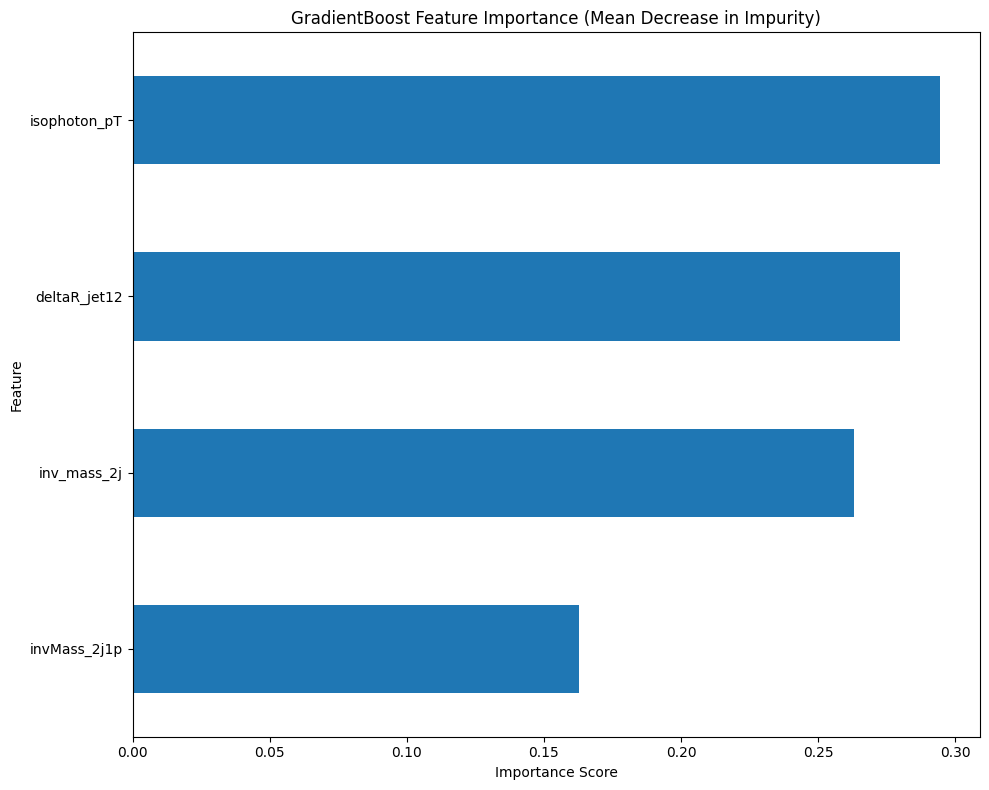

In [25]:
print("\n--- Calculating Impurity-Based Feature Importance (MDI) ---")
# Get importance scores directly from the trained model
gb_importances_mdi = best_model_gb.feature_importances_

# Create a Pandas Series for easy handling and sorting
gb_importances_mdi = pd.Series(gb_importances_mdi, index=features_col)
gb_importances_mdi = gb_importances_mdi.sort_values(ascending=False)

print(gb_importances_mdi)

# --- Visualize MDI Importances ---
plt.figure(figsize=(10, 8))
gb_importances_mdi.plot(kind='barh')
plt.title("GradientBoost Feature Importance (Mean Decrease in Impurity)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.tight_layout()
plt.show()

## Permutation Importance - GradientBoost


--- Calculating Permutation Importance (on Test Set) ---

Features Permutation Importance on Test Set, metric='roc_auc'):
isophoton_pT    0.153867
invMass_2j1p    0.054808
deltaR_jet12    0.026569
inv_mass_2j     0.008814
dtype: float64


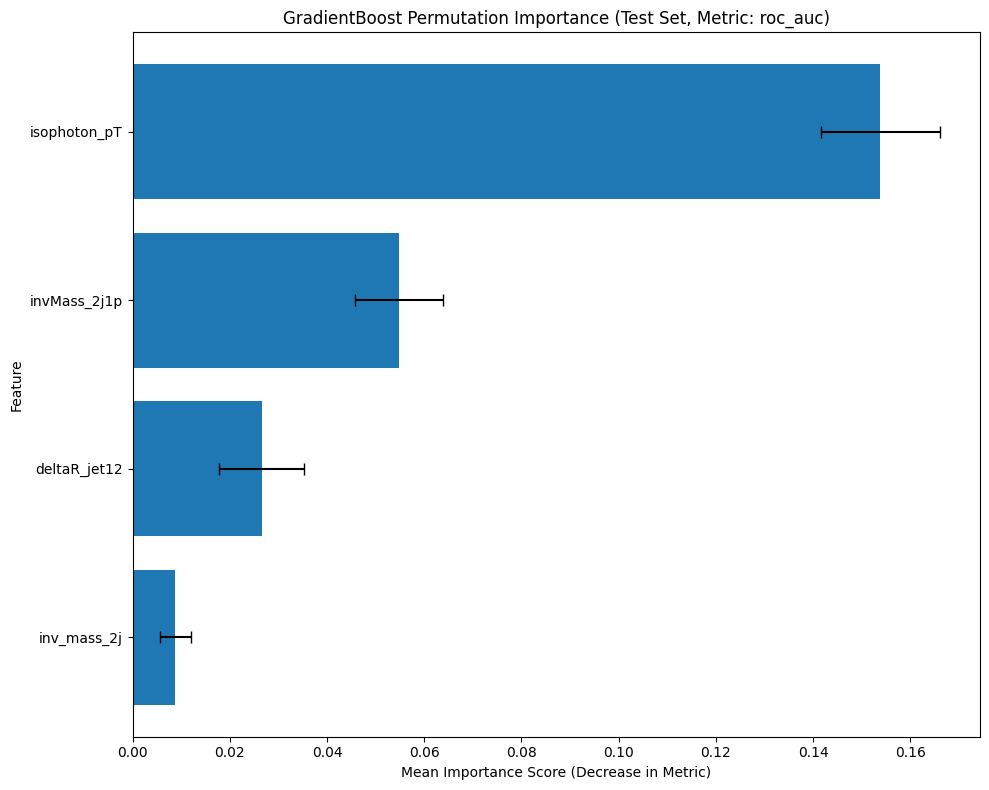

In [27]:
print("\n--- Calculating Permutation Importance (on Test Set) ---")


# Choose a scoring metric - accuracy, roc_auc, f1, balanced_accuracy etc.
# For imbalanced data, 'roc_auc', 'f1_weighted', or 'balanced_accuracy' are often better than 'accuracy'
scoring_metric = 'roc_auc'

# Calculate permutation importance
# n_repeats: Number of times to shuffle each feature for stability
gb_perm_importance_result = permutation_importance(
    estimator=best_model_gb,
    X=X_test,
    y=y_test,
    scoring=scoring_metric,
    n_repeats=10, # Increase for more stable results, but slower
    random_state=SEED,
    n_jobs=-1 # Use multiple cores if available
)

# Extract mean and standard deviation of importance scores
gb_importances_perm_mean = gb_perm_importance_result.importances_mean
gb_importances_perm_std = gb_perm_importance_result.importances_std

# Create a Pandas Series for easy handling
gb_perm_importances = pd.Series(gb_importances_perm_mean, index=features_col)
gb_perm_importances = gb_perm_importances.sort_values(ascending=False)

print(f"\nFeatures Permutation Importance on Test Set, metric='{scoring_metric}'):")
print(gb_perm_importances)

# --- Visualize Permutation Importances ---
plt.figure(figsize=(10, 8))
# Get sorted indices for plotting std deviations correctly
sorted_idx = gb_perm_importances.index
plt.barh(sorted_idx, gb_perm_importances[sorted_idx],
         xerr=gb_importances_perm_std[gb_perm_importances.index.get_indexer(sorted_idx)], # Map std dev to sorted order
         capsize=4)
plt.title(f"GradientBoost Permutation Importance (Test Set, Metric: {scoring_metric})")
plt.xlabel("Mean Importance Score (Decrease in Metric)")
plt.ylabel("Feature")
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.tight_layout()
plt.show()